In [1]:
from typing import Annotated
import os
from langchain_tavily import TavilySearch
from langchain_core.tools import tool
from typing_extensions import TypedDict
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_community.chat_models import ChatTongyi
from langgraph.types import Command, interrupt
from langchain_openai import ChatOpenAI



In [2]:
# os.environ["LANGSMITH_API_KEY"] = getpass.getpass("Enter your LangSmith API key: ")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "human_in_the_loop"

In [3]:
llm = ChatOpenAI(model="gpt-4o-mini")
#llm = ChatTongyi(model="qwen-max")

In [4]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

In [5]:
@tool
def human_assistance(query: str) -> str:
    """Request assistance from a human."""
    human_response = interrupt({"query": query})
    return human_response["data"]

tool = TavilySearch(max_results=2)
tools = [tool, human_assistance]
llm_with_tools = llm.bind_tools(tools)

In [6]:
def chatbot(state: State):
    message = llm_with_tools.invoke(state["messages"])
    # Because we will be interrupting during tool execution,
    # we disable parallel tool calling to avoid repeating any
    # tool invocations when we resume.
    assert len(message.tool_calls) <= 1
    return {"messages": [message]}

graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

In [7]:
memory = MemorySaver()

graph = graph_builder.compile(checkpointer=memory)

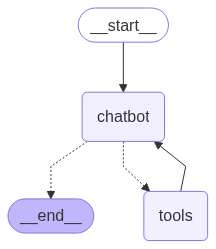

In [8]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [10]:
user_input = "I need some expert guidance for building an AI agent. Could you request assistance for me?"
config = {"configurable": {"thread_id": "1"}}

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I need some expert guidance for building an AI agent. Could you request assistance for me?
================================== Ai Message ==================================
Tool Calls:
  human_assistance (call_DhoA1M9yYSDEhHbleFCxsgon)
 Call ID: call_DhoA1M9yYSDEhHbleFCxsgon
  Args:
    query: I need expert guidance on building an AI agent. I'm looking for information on best practices, tools, technologies, and frameworks to use. Any recommendations or insights would be appreciated.


**The chatbot generated a tool call, but then execution has been interrupted.**

**If you inspect the graph state, you see that it stopped at the tools node**

chatbot产生了tool call的message，但tools节点没有执行，在tool内调用interrupt会中断执行，等待人类反馈。

In [11]:
snapshot = graph.get_state(config)

In [14]:
snapshot.next

('tools',)

In [17]:
snapshot.interrupts

(Interrupt(value={'query': "I need expert guidance on building an AI agent. I'm looking for information on best practices, tools, technologies, and frameworks to use. Any recommendations or insights would be appreciated."}, resumable=True, ns=['tools:c10b8a8e-c730-b882-be7a-53f734c816ff']),)

## Resume

In [18]:
human_response = (
    "We, the experts are here to help! We'd recommend you check out LangGraph to build your agent."
    " It's much more reliable and extensible than simple autonomous agents."
)

human_command = Command(resume={"data": human_response})

events = graph.stream(human_command, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  human_assistance (call_DhoA1M9yYSDEhHbleFCxsgon)
 Call ID: call_DhoA1M9yYSDEhHbleFCxsgon
  Args:
    query: I need expert guidance on building an AI agent. I'm looking for information on best practices, tools, technologies, and frameworks to use. Any recommendations or insights would be appreciated.
================================= Tool Message =================================
Name: human_assistance

We, the experts are here to help! We'd recommend you check out LangGraph to build your agent. It's much more reliable and extensible than simple autonomous agents.
================================== Ai Message ==================================

I received some expert guidance on building an AI agent. They recommend using **LangGraph** as a reliable and extensible option compared to simpler autonomous agents. This could provide you with a solid foundation for your project. If you need further d

In [22]:
to_replay = list(graph.get_state_history(config))[4]

In [27]:
to_replay.values['messages']

[HumanMessage(content='我想要了解中国目前有哪些热点新闻', additional_kwargs={}, response_metadata={}, id='9631e803-7132-42c6-b14f-7a72a5c831ae'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_XfGhBAk9ryL5Kbz0KHhLA0MA', 'function': {'arguments': '{"query":"中国 热点新闻","topic":"news","time_range":"week"}', 'name': 'tavily_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 29, 'prompt_tokens': 821, 'total_tokens': 850, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_efad92c60b', 'id': 'chatcmpl-BtsJ0t5eVjzMQopJc2g6gGqpBPm58', 'service_tier': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--2202d942-763d-4c27-89fc-7db1a5acee07-0', tool_calls=[{'name': 'tavily_search', 'args': {'query': '中国 热点新闻'

In [28]:
for event in graph.stream(None, to_replay.config, stream_mode="values"):
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================

以下是最近关于中国的一些热点新闻：

1. **台湾独立武装的战争挑衅将自取灭亡**  
   中国国防部发言人表示，台湾独立武装的战争挑衅是徒劳的，只会导致自我毁灭。更多详情请参阅 [China Daily](https://www.chinadaily.com.cn/a/202507/14/WS6874c9d0a31000e9a573bed2.html)。

2. **中国6月份出口增长5.8%**  
   报道称，由于美国关税的缓解，促使公司和消费者下单，中国的出口在6月加速增长，同比上升5.8%。详细信息请查看 [Greenwich Time](https://www.greenwichtime.com/news/world/article/china-s-exports-jump-5-8-in-june-as-tariffs-20768543.php)。

如果您想了解更多信息或其他方面的新闻，请告知我！
================================ Human Message =================================

I need some expert guidance for building an AI agent. Could you request assistance for me?
================================== Ai Message ==================================
Tool Calls:
  human_assistance (call_gIP0KNUXbzPNyVCQqg8ZMuGo)
 Call ID: call_gIP0KNUXbzPNyVCQqg8ZMuGo
  Args:
    query: I need expert guidance for building an AI agent. Can you provide advice on the best practices, tools, and methodologies to use?